# Connectivity
**Objetive:** <br>
The following notebook creates infrastructure and connectivity maps. The connectivity data is from Ookla Open Data Initiative, data from 2023-Q1. The health infrastructure data is from official records for 10 countries (see Section 2) and healthsites.io<br>

**Notes:** <br>
If you have little to no experience with Python but want to produce maps for a different country or for the region, follow these steps: 
1. Change the variable `code` in section 3. 
    * For regional (LAC-26) results `code = "LAC"`. 
    * For country-level results, please use the iso alpha-3 codes in this [link](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3), and replace `code` with the country-code of interest. 
2. In the menu (upper left side of the notebook) go to `Run` and select `Run All Cells`.
<br>
<br>

Author: Laura Goyeneche, Consultant SPH, lauragoy@iadb.org <br>
Created: Sept 19, 2023

## 1. Basics

In [1]:
# Library 
import os
import numpy as np
import pandas as pd
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import transform
from shapely.geometry import Point

In [2]:
%%capture
# Modules 
os.chdir(os.path.abspath('..'))
from source.utils import *
os.chdir(os.path.abspath('exercises'))

In [3]:
# Working environments
dotenv.load_dotenv()
sclbucket   = os.environ.get("sclbucket")
scldatalake = os.environ.get("scldatalake")

In [4]:
# Quantile labels function
def qcut_label(var):
    # Calculate quantiles 
    temp = pd.qcut(healthinfra[var_], q = 5)
    temp = temp.apply(lambda x: x.right)

    # Define intervals
    int_ = temp.unique()
    int_ = int_[~int_.isna()].tolist()
    int_.sort()
    
    # Define labels
    lab_ = [f"Q1: < {int_[0]:.0f} Mbps",f"Q2: {int_[0]:.0f}-{int_[1]:.0f} Mbps",f"Q3: {int_[1]:.0f}-{int_[2]:.0f} Mbps",f"Q4: {int_[2]:.0f}-{int_[3]:.0f} Mbps",f"Q5: > {int_[3]:.0f} Mbps"]
    lab_ = dict(zip(int_,lab_))
    
    # Create label variable
    temp = temp.astype(float).replace(lab_)
    
    return temp

## 2. Inputs

In [5]:
# Shapefiles
shp0 = get_country_shp(level = 0)
shp1 = get_country_shp(level = 1)
shp2 = get_country_shp(level = 2)

In [6]:
# Connectivity
fixed  = gpd.read_file(f"../data/3-connectivity/tiles-level/lac-26/fixed_connectivity_2023_q2.shp")
mobile = gpd.read_file(f"../data/3-connectivity/tiles-level/lac-26/mobile_connectivity_2023_q2.shp")

In [7]:
%%capture 
# Health infrastructure 
official = pd.read_csv(f"../data/0-raw/infrastructure/healthcare_facilities_official.csv")
official = official.drop(columns = "Unnamed: 0")
public   = pd.read_csv(f"../data/0-raw/infrastructure/healthcare_facilities_public.csv")
public   = public.drop(columns = "Unnamed: 0")

In [8]:
# List of countries with official records 
official.isoalpha3.unique().tolist()

['ARG', 'BRA', 'ECU', 'GTM', 'GUY', 'HND', 'JAM', 'MEX', 'PER', 'SLV']

## 3. Country of interest
Select country isoalpha-3 code based on `codes` list. If analysis for LAC, please replaces `code = "LAC"`

In [9]:
# LAC-26 codes 
data  = get_iadb()
codes = data.isoalpha3.tolist()

In [10]:
# Define country of interest
code = "BRA"

## 4. Preprocessing

In [11]:
# Filter shapefiles 
if code != "LAC":
    shp0 = shp0[shp0.ADM0_PCODE == code]
    shp1 = shp1[shp1.ADM0_PCODE == code]
    shp2 = shp2[shp2.ADM0_PCODE == code]

In [12]:
# Select health infrastructure 
if code in official.isoalpha3.unique():
    healthinfra_lab = "official records" 
    healthinfra     = official[official.isoalpha3 == code]
else:
    if code != "LAC":
        healthinfra_lab = "healthsites.io" 
        healthinfra     = public[public.isoalpha3 == code]
    else: 
        healthinfra = public

In [13]:
# Omit infra with NA
healthinfra = healthinfra[~healthinfra.lat.isna()]
healthinfra = healthinfra[~healthinfra.lon.isna()]

In [14]:
# Convert health lat-lon data to GeoDataFrame
geometry    = gpd.points_from_xy(healthinfra['lon'], healthinfra['lat'])
healthinfra = gpd.GeoDataFrame(healthinfra.copy(), geometry = geometry, crs = 4326)

In [15]:
%%time 
# Calculate buffer of 10 km around health centers
    # Reproject geometry
crs_ = healthinfra.crs
healthinfra = healthinfra.to_crs('EPSG:6588')

    # Calculate buffer in meters (10km)
distance = 10000
healthinfra["geometry"] = healthinfra.geometry.buffer(distance, cap_style = 1)

    # Reproject 
healthinfra = healthinfra.to_crs(crs_)

CPU times: user 40.4 s, sys: 0 ns, total: 40.4 s
Wall time: 40.4 s


In [18]:
# TEMPORARY: replace country codes 
# TODO     : Update codes in shapefile 
country_dict = {'BZ':'BLZ','BO':'BOL','BR':'BRA','BB':'BRB','CL':'CHL','CO':'COL','CR':'CRI','DO':'DOM','EC':'ECU',
                'GT':'GTM','GY':'GUY','HN':'HND','HT':'HTI','MX':'MEX','NI':'NIC','PA':'PAN','PE':'PER','PY':'PRY',
                'SV':'SLV','SR':'SUR','TT':'TTO','UY':'URY','VE':'VEN'}
fixed .ADM0_PCODE = fixed .ADM0_PCODE.replace(country_dict)
mobile.ADM0_PCODE = mobile.ADM0_PCODE.replace(country_dict)

In [19]:
# Select connectivity points in country of interest
if code != "LAC":
    fixed_  = fixed [fixed .ADM0_PCODE == code]
    mobile_ = mobile[mobile.ADM0_PCODE == code]
else: 
    fixed_  = fixed
    mobile_ = mobile

In [20]:
%%time
# Identify healthcenters with connectivity points nearby 
hc_mobile = gpd.sjoin(healthinfra, mobile_)
hc_mobile = hc_mobile.groupby("source_id")[['avg_d_mbps','avg_u_mbps']].mean().reset_index()
hc_mobile = hc_mobile.rename(columns = {"avg_d_mbps":"avg_d_mbps_mob","avg_u_mbps":"avg_u_mbps_mob"})
hc_fixed  = gpd.sjoin(healthinfra, fixed_)
hc_fixed  = hc_fixed.groupby("source_id")[['avg_d_mbps','avg_u_mbps']].mean().reset_index()
hc_fixed  = hc_fixed.rename(columns = {"avg_d_mbps":"avg_d_mbps_fix","avg_u_mbps":"avg_u_mbps_fix"})

CPU times: user 6min 18s, sys: 17.7 s, total: 6min 36s
Wall time: 6min 36s


In [21]:
# Merge with health infrastructure data 
healthinfra = healthinfra.merge(hc_mobile, on = "source_id", how = "left")
healthinfra = healthinfra.merge(hc_fixed , on = "source_id", how = "left")

In [22]:
# Identifty hospitals without connectivity
healthinfra["connectivity_mob"] = np.where((healthinfra.avg_d_mbps_mob.isna()) | (healthinfra.avg_u_mbps_mob.isna()),0,1)
healthinfra["connectivity_fix"] = np.where((healthinfra.avg_d_mbps_fix.isna()) | (healthinfra.avg_u_mbps_fix.isna()),0,1)

In [23]:
# Convert health lat-lon data to GeoDataFrame
geometry    = gpd.points_from_xy(healthinfra['lon'], healthinfra['lat'])
healthinfra = gpd.GeoDataFrame(healthinfra.copy(), geometry = geometry, crs = 4326)

## 5. Maps

In [24]:
# Identify country bounds 
bounds = shp0.geometry.bounds.values.flatten().tolist()
bounds = [np.floor(value)       if value < 0 else np.ceil(value)       for value in bounds]
bounds = [np.floor(value/10)*10 if value < 0 else np.ceil(value/10)*10 for value in bounds]
minx, miny, maxx, maxy = bounds

### 5.1. Health centers

In [25]:
# Results
print(f"Total number of health centers {healthinfra.shape[0]:,} in {code}")

Total number of health centers 432,180 in BRA


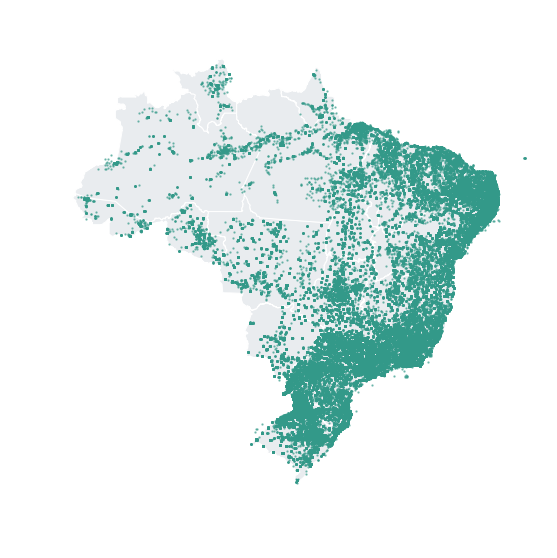

In [26]:
# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth  = 1, edgecolor = "white")
healthinfra.plot(ax = ax, color = "#339989", markersize = 2, alpha = 0.5)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis("off")
plt.show()

### 5.2. Mobile and fixed connectivity

#### Mobile connectivity

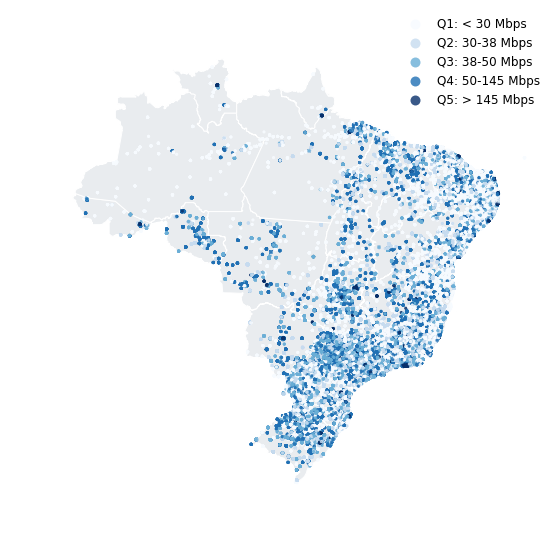

In [27]:
# Temporary variable
var_                = "avg_d_mbps_mob"
healthinfra["temp"] = qcut_label(var_)

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth  = 1, edgecolor = "white")
healthinfra.plot(ax = ax, column = "temp", cmap = "Blues", categorical = True, legend = True, alpha = 0.8, markersize = 5, legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis("off")
plt.show()

#### Fixed connectivity

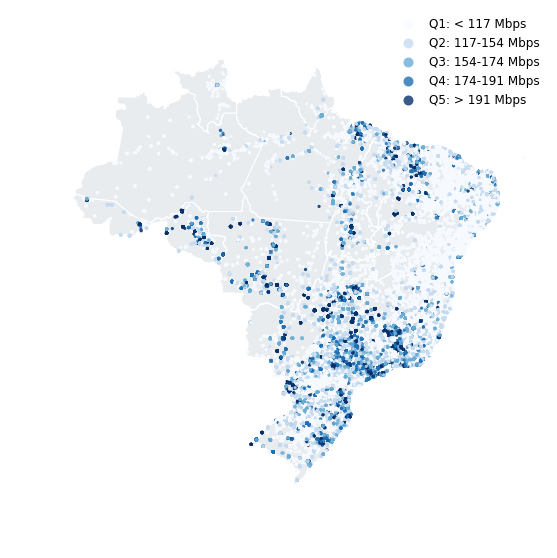

In [28]:
# Temporary variable
var_                = "avg_d_mbps_fix"
healthinfra["temp"] = qcut_label(var_)

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth  = 1, edgecolor = "white")
healthinfra.plot(ax = ax, column = "temp", cmap = "Blues", categorical = True, legend = True, alpha = 0.8, markersize = 5, legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis("off")
plt.show()

### 5.2. Health centers with or without connectivity (yes/no)

#### Mobile connectivity

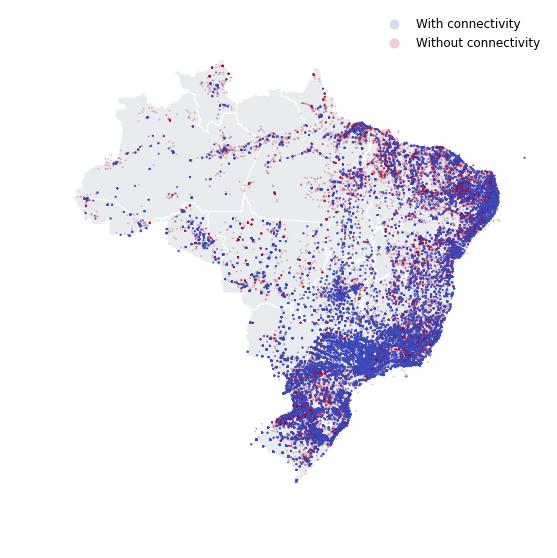

In [29]:
# Temporary variable
healthinfra["temp"] = np.where(healthinfra["connectivity_mob"] == 1, "With connectivity", "Without connectivity")

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth = 1, edgecolor = "white")
healthinfra.plot(ax = ax, column = "temp", cmap = "coolwarm", categorical = True, legend = True, alpha = 0.2, markersize = 1, legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis("off")
plt.show()

#### Fixed connectivity

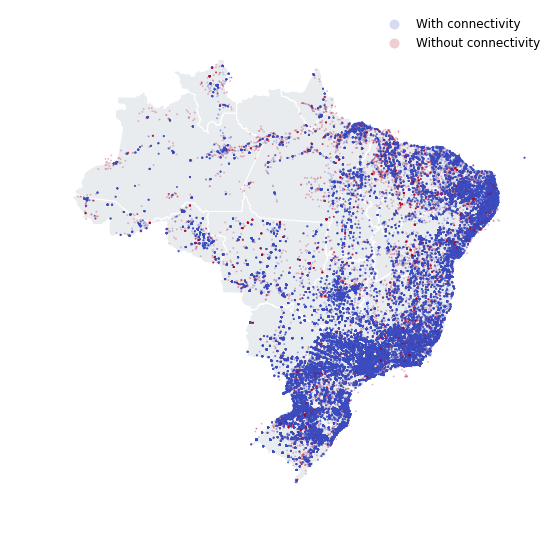

In [30]:
# Temporary variable
healthinfra["temp"] = np.where(healthinfra["connectivity_fix"] == 1, "With connectivity", "Without connectivity")

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth = 1, edgecolor = "white")
healthinfra.plot(ax = ax, column = "temp", cmap = "coolwarm", categorical = True, legend = True, alpha = 0.2, markersize = 1, legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis("off")
plt.show()

In [31]:
# Results
n_no_connec_mob = healthinfra.shape[0] - healthinfra.connectivity_mob.sum()
n_no_connec_fix = healthinfra.shape[0] - healthinfra.connectivity_fix.sum()
p_no_connec_mob = (n_no_connec_mob / healthinfra.shape[0]) * 100
p_no_connec_fix = (n_no_connec_fix / healthinfra.shape[0]) * 100

print(f"{n_no_connec_mob:,} ({p_no_connec_mob:.1f}%) health centers are located in areas without mobile connectivity")
print(f"{n_no_connec_fix:,} ({p_no_connec_fix:.1f}%) health centers are located in areas without fixed connectivity")
print(f"\nSource: Health centers from {healthinfra_lab} and connectivity data from Ookla Open Data Initiative, data from 2023-Q1")
print(f"Notes: A health center is considered to have connectivity if Ookla identifies at least one point with connectivity within a 10 km radius of the health center.")

16,551 (3.8%) health centers are located in areas without mobile connectivity
6,503 (1.5%) health centers are located in areas without fixed connectivity

Source: Health centers from official records and connectivity data from Ookla Open Data Initiative, data from 2023-Q1
Notes: A health center is considered to have connectivity if Ookla identifies at least one point with connectivity within a 10 km radius of the health center.


### 5.3. Health centers with low or high connectivity

#### Mobile connectivity

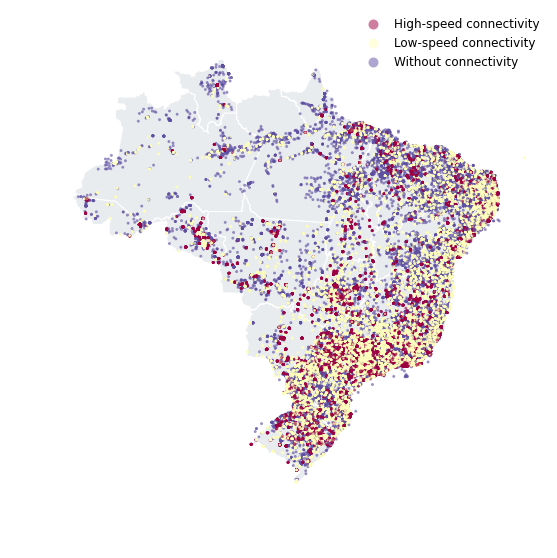

In [32]:
# Temporary variable
var_                = "avg_d_mbps_mob"
healthinfra["temp"] = qcut_label(var_)

group = healthinfra.temp.unique()
group = [x for x in group if str(x)[0] == "Q"]
group.sort()

healthinfra["temp_"] = np.where(healthinfra.temp.isna()         ,"Without connectivity"   ,"")
healthinfra["temp_"] = np.where(healthinfra.temp.isin(group[:3]),"Low-speed connectivity" ,healthinfra.temp_)
healthinfra["temp_"] = np.where(healthinfra.temp.isin(group[3:]),"High-speed connectivity",healthinfra.temp_)

healthinfra["size_"] = np.where(healthinfra.temp_ == "Without connectivity"  ,1,0)
healthinfra["size_"] = np.where(healthinfra.temp_ == "Low-speed connectivity",2,4)

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth = 1, edgecolor = "white")
healthinfra.plot(ax = ax, column = "temp_", cmap = "Spectral", categorical = True, legend = True, alpha = 0.5, markersize = "size_", legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis("off")
plt.show()

In [33]:
# Results 
main_ = healthinfra.temp_.value_counts(dropna = False).reset_index()
main_ = main_.rename(columns = {"temp_":'# health centers'})
main_["% health centers"] = main_["# health centers"] * 100 / main_["# health centers"].sum()
print(main_)

print(f"\nSource: Health centers from {healthinfra_lab} and connectivity data from Ookla Open Data Initiative, data from 2023-Q1")
print(f"Notes: A health center is considered to have low and high connectivity if the average download level is less than and higher than Q3, respectively.")

                     index  # health centers  % health centers
0   Low-speed connectivity            249394         57.706048
1  High-speed connectivity            166235         38.464297
2     Without connectivity             16551          3.829654

Source: Health centers from official records and connectivity data from Ookla Open Data Initiative, data from 2023-Q1
Notes: A health center is considered to have low and high connectivity if the average download level is less than and higher than Q3, respectively.


#### Fixed connectivity

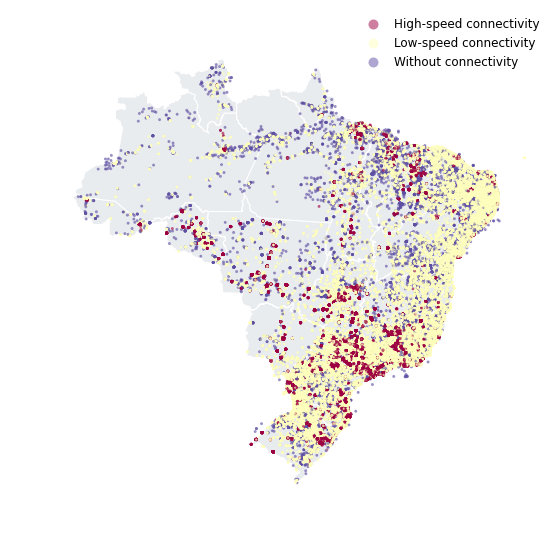

In [34]:
# Temporary variable
var_                = "avg_d_mbps_fix"
healthinfra["temp"] = qcut_label(var_)

group = healthinfra.temp.unique()
group = [x for x in group if str(x)[0] == "Q"]
group.sort()

healthinfra["temp_"] = np.where(healthinfra.temp.isna()         ,"Without connectivity"   ,"")
healthinfra["temp_"] = np.where(healthinfra.temp.isin(group[:3]),"Low-speed connectivity" ,healthinfra.temp_)
healthinfra["temp_"] = np.where(healthinfra.temp.isin(group[3:]),"High-speed connectivity",healthinfra.temp_)

healthinfra["size_"] = np.where(healthinfra.temp_ == "Without connectivity"  ,1,0)
healthinfra["size_"] = np.where(healthinfra.temp_ == "Low-speed connectivity",2,4)

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth = 1, edgecolor = "white")
healthinfra.plot(ax = ax, column = "temp_", cmap = "Spectral", categorical = True, legend = True, alpha = 0.5, markersize = "size_", legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis("off")
plt.show()

In [35]:
# Results 
main_ = healthinfra.temp_.value_counts(dropna = False).reset_index()
main_ = main_.rename(columns = {"temp_":'# health centers'})
main_["% health centers"] = main_["# health centers"] * 100 / main_["# health centers"].sum()
print(main_)

print(f"\nSource: Health centers from {healthinfra_lab} and connectivity data from Ookla Open Data Initiative, data from 2023-Q1")
print(f"Notes: A health center is considered to have low and high connectivity if the average download level is less than and higher than Q3, respectively.")

                     index  # health centers  % health centers
0   Low-speed connectivity            255406         59.097135
1  High-speed connectivity            170271         39.398167
2     Without connectivity              6503          1.504697

Source: Health centers from official records and connectivity data from Ookla Open Data Initiative, data from 2023-Q1
Notes: A health center is considered to have low and high connectivity if the average download level is less than and higher than Q3, respectively.
